# Analytic Ising Model
We try analytically solve the inverse Ising problem using the Wolfram language. As we go along, I will explain aspects of the Wolfram language that were not obvious to me.

### Set no. of neurons/spins:

In [ ]:
NN = 2

### Construct the Hamiltonian

In [2]:
Hamiltonian =  Sum[J[i, j] s[i] s[j], {j, 1, NN}, {i, 1,j-1}] + 
    Sum[ H[i] s[i], {i, 1, NN}] // Expand

H[1] s[1] + H[2] s[2] + J[1, 2] s[1] s[2]

In Wolfram, named functions take the form `Function[ args ]`. An important concept is that of [iterators](https://www.wolfram.com/language/fast-introduction-for-programmers/en/iterators/). For instance, the function `Sum[ i, {i,1,5,2} ]` will sum over the variable `i` from `1` to `5` incrementing by `2` each time. 

In [4]:
Sum[i,{i,1,5,2}]

9

### Construct the partition function `Z`
We can choose to represent whether the neuron is silent or fires as either {0,1}, or as {-1,1}. 

In [14]:
spinvals = (PadLeft[IntegerDigits[#, 2], NN] & /@ 
     Range[0, 2^NN - 1]) /. {0 -> -1}
reps = Table[s[i] -> #[[i]], {i, NN}] & /@ spinvals
Z = Total[(Exp[-Hamiltonian] /. reps)] // ExpToTrig // FullSimplify

{{-1, -1}, {-1, 1}, {1, -1}, {1, 1}}
{{s[1] -> -1, s[2] -> -1}, {s[1] -> -1, s[2] -> 1}, {s[1] -> 1, s[2] -> -1}, 
 
>   {s[1] -> 1, s[2] -> 1}}
4 Cosh[H[1]] Cosh[H[2]] Cosh[J[1, 2]] - 4 Sinh[H[1]] Sinh[H[2]] Sinh[J[1, 2]]

One can define lambda functions, called *pure functions* by writing a function in terms of `#`s and ending it with a `&`. To then apply the function over multiple expressions, one can map it using `\@`. For instance, below we construct the pure function that squares its argument `#^2&`, and then we apply to a list of containing the lists `{0,1}` and `{2,3}`. 

In [8]:
#^2& /@ {{0,1},{2,3}}

{{0, 1}, {4, 9}}

Once we have an expression, for instance `x + y + z`, we can replace symbols with other ones. `/.` means *replace everywhere*. Below, we show how we can use it to replace `x` with `2` and `y` with `3`. It sort of copies the expression into the curly brackets and implements the suggested replacements.

In [9]:
x + y + z /. {x->2, y->3}
x + y + z /. {{{x->2}, {y->3}}, {y->3}}

5 + z
{{2 + y + z, 3 + x + z}, 3 + x + z}

### Construct the probability distributionn `p`.

-(H[1] s[1]) - H[2] s[2] - J[1, 2] s[1] s[2]
                E
-----------------------------------------------------------------------------
4 Cosh[H[1]] Cosh[H[2]] Cosh[J[1, 2]] - 4 Sinh[H[1]] Sinh[H[2]] Sinh[J[1, 2]]
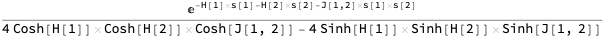

In [17]:
p = Exp[-Hamiltonian]/Z 

We can evaluate this expression at a particular configuration as follows (assuming we have 2 neurons):

H[1] - H[2] + J[1, 2]
                           E
-----------------------------------------------------------------------------
4 Cosh[H[1]] Cosh[H[2]] Cosh[J[1, 2]] - 4 Sinh[H[1]] Sinh[H[2]] Sinh[J[1, 2]]
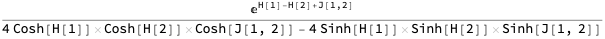

In [18]:
p /. {s[1]-> -1, s[2]->1}

### Compute the expectations and correlations
When we represent the neuron states as `{-1,1}`, the auto-correlations are 1 since we either have `1*1` times a probability, or `-1*-1=1` times a probability, and all the probabilities sum to 1. On the other hand, when we represent the neuron states as `{0,1}`, the auto-correlations are equal to the expectations since the product of a neuron with itself takes on the same values as just the neuron by itself.   

-(Cosh[H[2]] Cosh[J[1, 2]]) + Coth[H[1]] Sinh[H[2]] Sinh[J[1, 2]]
{-----------------------------------------------------------------, 
  Cosh[H[2]] Cosh[J[1, 2]] Coth[H[1]] - Sinh[H[2]] Sinh[J[1, 2]]
 
    -(Cosh[H[1]] Cosh[J[1, 2]]) + Coth[H[2]] Sinh[H[1]] Sinh[J[1, 2]]
>   -----------------------------------------------------------------}
     Cosh[H[1]] Cosh[J[1, 2]] Coth[H[2]] - Sinh[H[1]] Sinh[J[1, 2]]
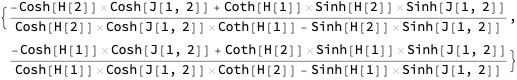

In [19]:
Averages = Table[ Total[s[i] p /. reps] // ExpToTrig // FullSimplify, {i,NN} ]

Note, we only work out the upper triangle of the correlation matrix. (Could I even leave out the diagonal?)

1
 
     Cosh[J[1, 2]] - Coth[H[1]] Coth[H[2]] Sinh[J[1, 2]]
     ---------------------------------------------------
>    Cosh[J[1, 2]] Coth[H[1]] Coth[H[2]] - Sinh[J[1, 2]]



0
 


>    1
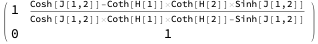

In [20]:
(CorrMatrix = 
  Table[Total[s[i] s[j] p /. reps] // ExpToTrig // FullSimplify, {i, 
    NN}, {j, i, NN}]) // PadLeft // MatrixForm

## Solve for `H` and `J` given observed expectations and correlations

Let us say that we observe the expectations of 2 neurons, as well as their correlation. Can we find the `H` and `J` that gives us an Ising model that reproduces these statistics?

If we try analytically for expected values `a[1]` and `a[2]`, and correlation `b`, this takes forever. 

In [ ]:
Solve[{Averages[[1]]==a[1],Averages[[2]]==a[2], CorrMatrix[[1,2]]==b}]

On the other hand, we can find values for `H` and `J` numerically. Let us say neuron 1 has an expected value of 0.1, neuron 2 has an expected value of 0.9 and their correlation is 0.1 (every time neuron 1 fires, so does neuron 2)

In [ ]:
g = NSolve[{Averages[[1]]==0.1, Averages[[2]]==0.9, CorrMatrix[[1,2]]==0.05}, {H[1], H[2], J[1,2]}]

Plug in `H` and `J` and check expectations and correlations are reproduced.

In [10]:
Table[ Total[s[i] p /. g /. reps], {i,NN} ]

{{0.1}, {0.9}}

In [11]:
Total[s[1] s[2] p /. g /. reps]

{0.05}

In [13]:
Total[s[1] s[1] p /. g /. reps]
Total[s[2] s[2] p /. g /. reps]

{0.9}